In [17]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
# Create object points and image points to be fed to calibrateCamera


objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []

images = glob.glob('camera_cal/cal*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

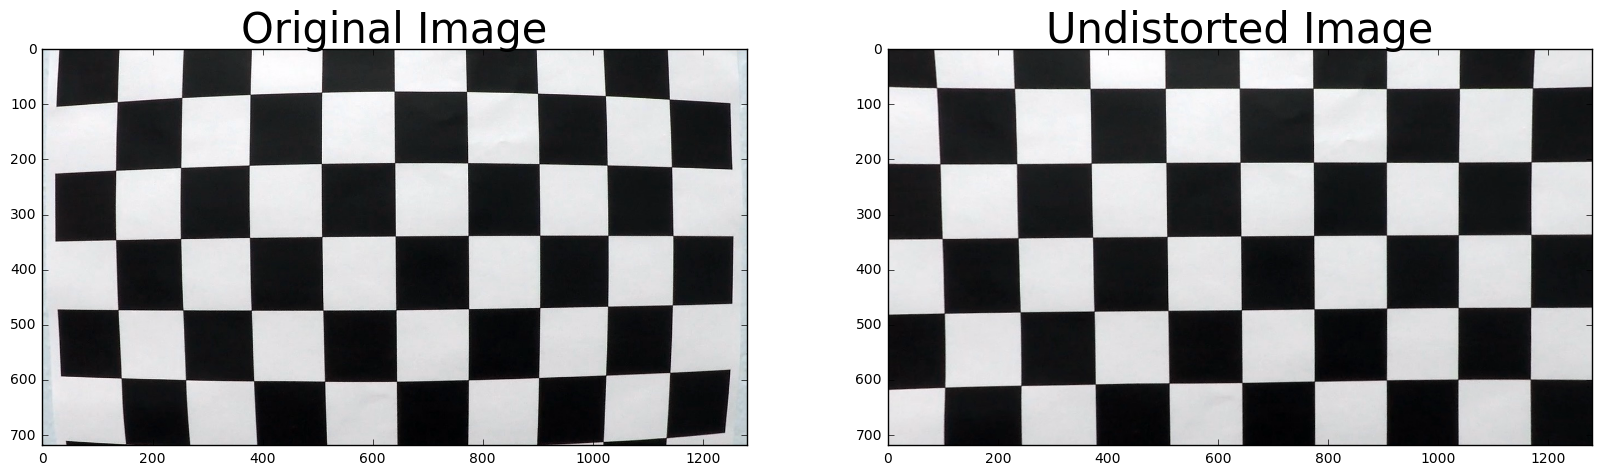

In [3]:
# Calibrate the camera, calculation camera and ditortion matrices

%matplotlib inline

img = cv2.imread('camera_cal/test_image.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

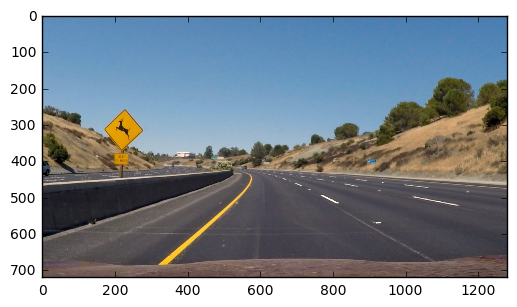

In [4]:
#Display a sample image

sample_img = mpimg.imread('test_images/test2.jpg')
plt.imshow(sample_img)

In [5]:
#Undistort the sample image
#Test points to be used for perspective transfrom

sample_undistorted = cv2.undistort(sample_img, mtx, dist, None, mtx)
plt.imshow(sample_undistorted)

plt.plot(500,500,'.')
plt.plot(840,500,'.')
plt.plot(1180,680,'.')
plt.plot(280,680,'.')

plt.plot(280,0,'.')
plt.plot(1180,0,'.')
plt.plot(1180,680,'.')
plt.plot(300,680,'.')

In [6]:
#Perspective and reverse perspective functions
#Apply the perspective function to sample image for verification

def perspective(img):
    #src = np.float32 ([[500,500] , [840,500] , [1180,680] , [280,680]] )
    src = np.float32 ([[600,450] , [750,450] , [1180,680] , [280,680]] )
    dst = np.float32 ([[280,0] , [1180,0] , [1180,680] , [300,680]] )
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def unperspective(img):        
    #src = np.float32 ([[500,500] , [840,500] , [1180,680] , [280,680]] )
    src = np.float32 ([[600,450] , [750,450] , [1180,680] , [280,680]] )
    dst = np.float32 ([[280,0] , [1180,0] , [1180,680] , [300,680]] )
    img_size = (img.shape[1], img.shape[0])
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return warped

#######
sample_perspective = perspective(sample_undistorted)
plt.imshow(sample_perspective,cmap='gray')  

In [7]:
# Function to apply gradient ad color thresholds

def apply_threshold(img, s_thresh=(100, 255), sx_thresh=(30, 100) ,sobel_kernel=9):

    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
        
    sxbinary = np.zeros_like(gradmag)
    sxbinary[(gradmag >= sx_thresh[0]) & (gradmag <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

##################

sample_thresholded = apply_threshold(sample_undistorted )
plt.imshow(sample_thresholded,cmap='gray')

In [8]:
#Function to mask the image, filtering pixels which are not part of the road, as much as possible

left_bottom_out = [250, 670]; left_top_out = [550,400] ;right_top_out = [780, 400]; right_bottom_out = [1100, 670] 
left_bottom_in = [400, 680]; left_top_in = [650,450] ;right_top_in = [700, 450]; right_bottom_in = [950, 680] 

#mask_points = np.int32( [ np.array([left_bottom_out , left_top_out, right_top_out,right_bottom_out , right_bottom_in , right_top_in,left_top_in,left_bottom_in] ) ]  )     
mask_points = np.int32( [ np.array([left_bottom_out , left_top_out, right_top_out,right_bottom_out ] ) ]  )     

def region_of_interest(img, vertices):
    
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#######

sample_masked = region_of_interest(sample_thresholded, mask_points)
plt.imshow(sample_masked,cmap='gray')   

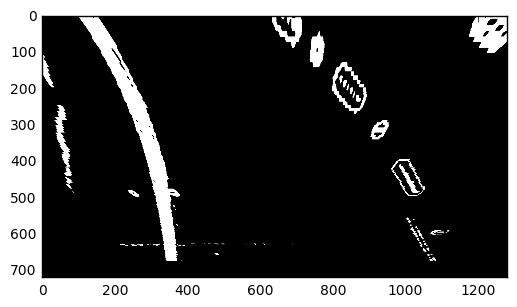

In [9]:
#Apply perspective transform to previous step, creating the warped image

sample_warped = perspective(sample_masked)
plt.imshow(sample_warped,cmap='gray')    

In [10]:
#Apply mask to warped image

left_bottom_out = [200, 720]; left_top_out = [200,0] ;right_top_out = [1100, 0]; right_bottom_out = [1100, 720] 
left_bottom_in = [400, 720]; left_top_in = [550,300] ;right_top_in = [850, 300]; right_bottom_in = [950, 720] 

mask_points_1 = np.int32( [ np.array([left_bottom_out , left_top_out, right_top_out,right_bottom_out ,right_bottom_in, right_top_in,left_top_in, left_bottom_in] ) ]  )     

sample_warped_masked = region_of_interest(sample_warped,mask_points_1)
plt.imshow(sample_warped_masked,cmap='gray')  

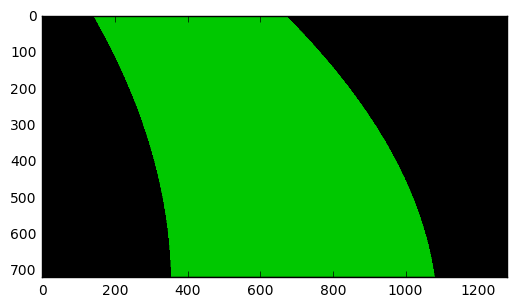

In [29]:
# Search for curves in warped image. Fit second order polynomial to the curves
#Calculate curvature radius and distance from the center


left_curverad = 0
right_curverad = 0

deviation = 0
deviation_direction = "?"

def search_lines(binary_warped):

    global left_curverad 
    global right_curverad 
    global deviation
    global deviation_direction

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
   
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    blank_image = np.zeros((720,1280,3), np.uint8)
    
    # Fit a second order polynomial to each
    
    if lefty.size ==0 or leftx.size ==0:
        return blank_image
             
    if righty.size==0 or rightx.size ==0:    
        return blank_image
        
    left_fit = np.polyfit(lefty, leftx, 2) 
    right_fit = np.polyfit(righty, rightx, 2)

    #########################

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #for i in range(719):
    #    result = cv2.line(blank_image, (int(left_fitx[i]), int(ploty[i])), (int(left_fitx[i+1]), int(ploty[i+1])), [255, 0, 0] , 50)

    for i in range(719):    
        result = cv2.line(blank_image, (int(left_fitx[i]), int(ploty[i])), (int(right_fitx[i]), int(ploty[i])), [0, 200, 0] , 1)    
        
    #for i in range(719):
    #    result = cv2.line(blank_image, (int(right_fitx[i]), int(ploty[i])),(int(right_fitx[i+1]),int(ploty[i+1])), [255, 0, 0] , 50)
                

        
        
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
             
    center_x = abs(right_fitx[719] - left_fitx[719])/2 + left_fitx[719]
    deviation = abs(640-center_x) *  xm_per_pix
        
    if center_x > 640:
        deviation_direction = "right"
    else:
        deviation_direction = "left"
                        
    return result

########
    
plt.imshow(search_lines(sample_warped_masked))

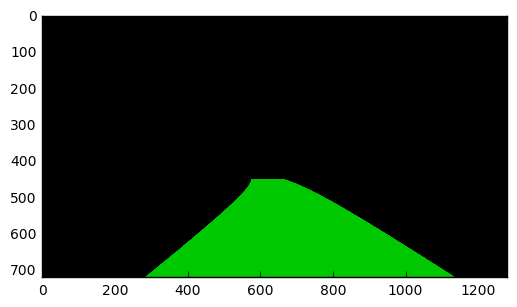

In [30]:
#Apply reverse perspective

unperspective_blank_image = unperspective(search_lines(sample_warped))
plt.imshow(unperspective_blank_image)

In [31]:
#Combine original image with lines area

xyz = cv2.addWeighted(sample_img, 1, unperspective_blank_image, 0.9, 0.0)
plt.imshow(xyz,cmap='gray')

In [32]:
#Build the pipeline combining the steps above

def pipeline(img):   
                   
    img_undistorted = cv2.undistort(img, mtx, dist, None, mtx)      
    img_thresholded = apply_threshold(img_undistorted)    
    img_masked = region_of_interest(img_thresholded, mask_points)    
    img_warped = perspective(img_masked)        
    img_warped_masked = region_of_interest(img_warped,mask_points_1)          
    img_lines = search_lines(img_warped_masked)
    img_lines_unperspective = unperspective(img_lines)
    img_final = cv2.addWeighted(img, 1, img_lines_unperspective, 0.8, 0.0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX    
    line1 = "Radius of curvature = " + str( round( (left_curverad+right_curverad)/2 )) + " m"
    img_final = cv2.putText(img_final, line1, (50,70) , font, 1.5, (255,255,255), 5, cv2.LINE_AA) 
       
    line3 = "Vehicle is " + str(round(deviation,3)) + " m " + deviation_direction + " of the center"
    img_final = cv2.putText(img_final, line3, (50,130) , font, 1.5, (255,255,255), 5, cv2.LINE_AA) 
    
    return img_final


def process_image(img):    
    result = pipeline(img)
    return result

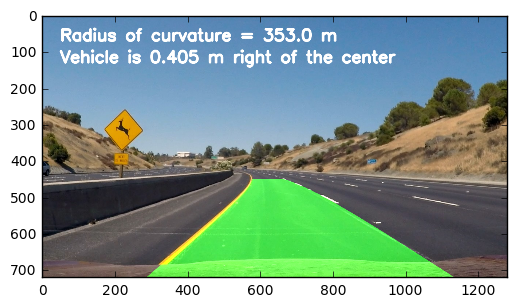

In [33]:
xyz_test = process_image(sample_img)
plt.imshow(xyz_test)

In [34]:
#Generate output video

project_video_output = 'first.mp4'
clip1 = VideoFileClip("project_video.mp4")
first_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time first_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video first.mp4
[MoviePy] Writing video first.mp4


100%|█████████▉| 1260/1261 [03:34<00:00,  5.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: first.mp4 

CPU times: user 13min 23s, sys: 1min 27s, total: 14min 50s
Wall time: 3min 35s
